In [1]:
import transformers
print(transformers.__version__)


4.51.3


In [2]:

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

In [3]:
dataset_path = 'preprocessed_bangla_1.csv'

In [4]:
df = pd.read_csv(dataset_path, encoding='utf-8-sig')

In [5]:
print(df.head()['cleaned_text'])

0    ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...
1                         অরে বাবা, এই টা কোন পাগল????
2                                ক্যাপ্টেন অফ বাংলাদেশ
3                     অন্যরকম .. ভালো লাগলো ..redheart
4    মোহাম্মদ কফিল উদ্দীন মাহমুদridwan romeldwaipay...
Name: cleaned_text, dtype: object


In [6]:
# Preprocessing
classes = df['label'].unique()
class_to_id = {cls: idx for idx, cls in enumerate(classes)}
id_to_class = {idx: cls for cls, idx in class_to_id.items()}

In [7]:
df = df.drop(columns=['comments'])

In [8]:
# Map class labels to IDs
df['label'] = df['label'].map(class_to_id)

In [9]:
print(df.head())

   label                                       cleaned_text
0      0  ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...
1      0                       অরে বাবা, এই টা কোন পাগল????
2      0                              ক্যাপ্টেন অফ বাংলাদেশ
3      0                   অন্যরকম .. ভালো লাগলো ..redheart
4      0  মোহাম্মদ কফিল উদ্দীন মাহমুদridwan romeldwaipay...


In [10]:
# Print unique classes
print("Unique Classes:", classes)

Unique Classes: ['not bully' 'religious' 'sexual' 'others']


In [11]:
# Print the mapping from class labels to IDs
print("Class to ID Mapping:", class_to_id)

Class to ID Mapping: {'not bully': 0, 'religious': 1, 'sexual': 2, 'others': 3}


In [12]:
# Print the mapping from IDs back to class labels
print("ID to Class Mapping:", id_to_class)

ID to Class Mapping: {0: 'not bully', 1: 'religious', 2: 'sexual', 3: 'others'}


In [13]:
# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_text'].values, df['label'].values, test_size=0.2, random_state=42
)

In [14]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

In [15]:
# Tokenize the text
def tokenize_function(texts):
    # Ensure all elements are strings
    texts = [str(text) for text in texts]  # Convert each element to string explicitly
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

In [16]:
train_texts.size

19472

In [17]:
# Example: Get tokenized text for the first row of train_texts
row_index = 0  # Index of the row you want to examine
input_ids = train_encodings['input_ids'][row_index]  # Get the token IDs for the row

# Decode the token IDs back to text
tokenized_text = tokenizer.decode(input_ids)

# Print the tokenized text
print(f"Original Text: {train_texts[row_index]}")
print(f"Tokenized Text: {tokenized_text}")

Original Text: তোসিফ সাফার কবির এর দালাল হইছেতৌসিফ ও নাস্তিক হইতে চায়
Tokenized Text: <s> তোসিফ সাফার কবির এর দালাল হইছেতৌসিফ ও নাস্তিক হইতে চায়</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU is available and being used: NVIDIA GeForce RTX 3070


In [19]:
# Create a custom dataset class
class CyberbullyingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [20]:
train_dataset = CyberbullyingDataset(train_encodings, train_labels)
test_dataset = CyberbullyingDataset(test_encodings, test_labels)

In [21]:
# # Display a few samples from train_dataset
# print("Sample Data from train_dataset:")
# for i in range(5):  # Display first 5 samples
#     print(train_dataset[i])


In [22]:
from transformers import XLMRobertaForSequenceClassification

# Load the PyTorch-compatible mBERT model for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=len(classes))

# Move the model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
import evaluate

metric = evaluate.load("accuracy")

In [25]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)

In [26]:
from transformers import get_scheduler

In [29]:
# Define the learning rate scheduler
num_training_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    "linear",  # Options: 'linear', 'cosine', 'constant', etc.
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

In [30]:
# Set up Trainer
training_args = TrainingArguments(
    output_dir="./resultsBERT0/T",  # Directory to save model checkpoints and logs
    num_train_epochs=2,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.05,  # Weight decay (L2 regularization)
    logging_dir="./logs",  # Directory for storing logs
    logging_steps=200,  # Log metrics every 200 steps
    eval_strategy="epoch",  # Evaluate the model at the end of every epoch
    save_strategy="epoch",  # Save model at the end of every epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)


In [31]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.608400,0.558309,0.798521
2,0.469200,0.461853,0.847402


TrainOutput(global_step=2434, training_loss=0.6699251940530544, metrics={'train_runtime': 508.7492, 'train_samples_per_second': 76.549, 'train_steps_per_second': 4.784, 'total_flos': 2561695235014656.0, 'train_loss': 0.6699251940530544, 'epoch': 2.0})

In [32]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

Evaluation Results: {'eval_loss': 0.46185269951820374, 'eval_accuracy': 0.8474019305812281, 'eval_runtime': 12.9311, 'eval_samples_per_second': 376.535, 'eval_steps_per_second': 23.587, 'epoch': 2.0}


In [33]:
from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_dataset)

# Get predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8474019305812281


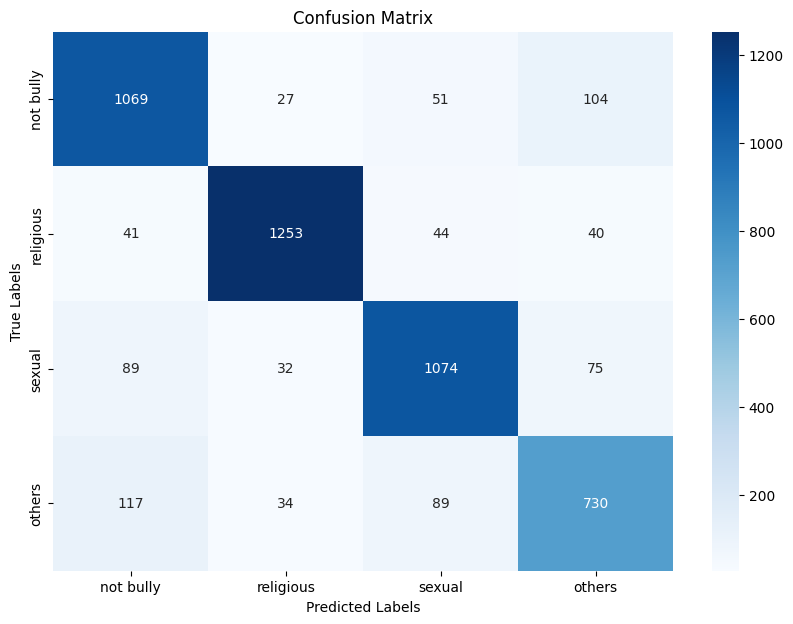

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get model predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert logits to predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute metrics
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average="weighted")

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.8474
Test Precision: 0.8481
Test Recall: 0.8474
Test F1 Score: 0.8476


In [36]:
train_results = trainer.evaluate(train_dataset)
print("Training Set Metrics:", train_results)


Training Set Metrics: {'eval_loss': 0.3880424201488495, 'eval_accuracy': 0.8706347576006573, 'eval_runtime': 50.7944, 'eval_samples_per_second': 383.349, 'eval_steps_per_second': 23.959, 'epoch': 2.0}


In [37]:
import torch

# Define the path to save the model
model_path = "xlmr_model.pth"  # This will save in the same directory as the notebook

# Save only the model's weights
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")


Model weights saved to xlmr_model.pth


In [38]:
torch.save(train_dataset, "xlmr_train_dataset.pth")


In [39]:
torch.save(test_dataset, "xlmr_test_dataset.pth")

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from collections import Counter
from transformers import XLMRobertaForSequenceClassification

# Define the same model architecture
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=4)

# Load the saved weights
xlmr_model.load_state_dict(torch.load("xlmr_model.pth", map_location=torch.device('cpu')))

# Set the model to evaluation mode
xlmr_model.eval()

print("xlmr model loaded successfully!")



from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
class CyberbullyingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
        
xlmr_test_dataset = torch.load("xlmr_test_dataset.pth")


def evaluate_model(model, test_dataset, batch_size=16):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds, all_labels


xlmr_accuracy, predictions, true_labels = evaluate_model(xlmr_model, xlmr_test_dataset)

print(f"xlmr Model Accuracy: {xlmr_accuracy:.4f}")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_18676\2812716422.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

xlmr model loaded successfully!


C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_18676\2812716422.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xlmr_test_dataset = torch.load("xlmr_test_dataset.pth")


xlmr Model Accuracy: 0.8474


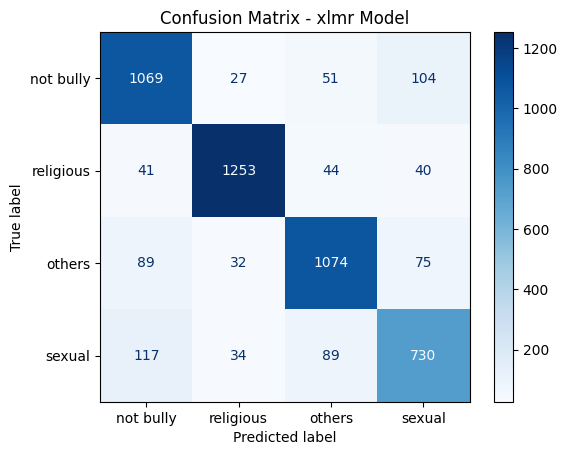

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_fscore_support,
    roc_auc_score,
    cohen_kappa_score
)
from sklearn.preprocessing import label_binarize


class_names = ['not bully', 'religious', 'others', 'sexual']

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - xlmr Model")
plt.show()


In [4]:
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

   not bully       0.81      0.85      0.83      1251
   religious       0.93      0.91      0.92      1378
      others       0.85      0.85      0.85      1270
      sexual       0.77      0.75      0.76       970

    accuracy                           0.85      4869
   macro avg       0.84      0.84      0.84      4869
weighted avg       0.85      0.85      0.85      4869



In [5]:
kappa = cohen_kappa_score(true_labels, predictions)
print(f"\nCohen's Kappa Score: {kappa:.4f}")


Cohen's Kappa Score: 0.7955


In [6]:
def evaluate_logits(model, test_dataset, batch_size=16):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating (for ROC-AUC)"):
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)


probs, y_true = evaluate_logits(xlmr_model, xlmr_test_dataset)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
roc_auc = roc_auc_score(y_true_bin, probs, average='macro')
print(f"\nMacro ROC-AUC Score: {roc_auc:.4f}")


Evaluating (for ROC-AUC):   0%|                                                                | 0/305 [00:00<?, ?it/s]C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_18676\2812716422.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating (for ROC-AUC): 100%|██████████████████████████████████████████████████████| 305/305 [00:12<00:00, 24.49it/s]


Macro ROC-AUC Score: 0.9612


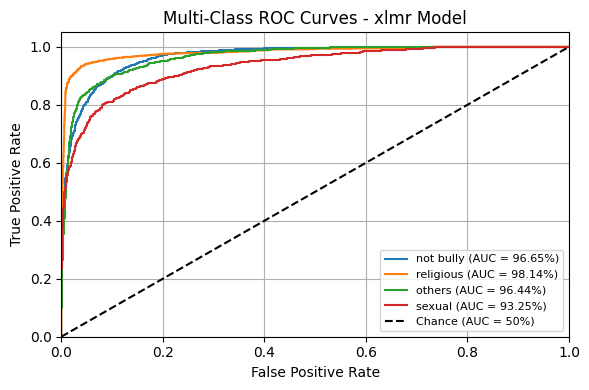

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Your class names
class_names = ['not bully', 'religious', 'others', 'sexual']

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create single ROC plot
plt.figure(figsize=(6, 4))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]*100:.2f}%)")

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 50%)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves - xlmr Model')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.savefig("xlmr_roc_curve.png", dpi=300)
plt.show()


In [8]:
import os
import torch
model_size_kb = os.path.getsize("xlmr_model.pth") / 1024
print(f"Model size: {model_size_kb:.0f} KB")

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=4)

# Count trainable parameters
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameter count: {param_count}")


Model size: 1086202 KB


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter count: 278046724


In [9]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(true_labels, predictions)
print(f"MCC: {mcc * 100:.2f}%")


MCC: 79.56%
